In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Symptom2Disease.csv")
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [3]:
df['label'].value_counts()

label
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: count, dtype: int64

# Natural Language Processing

## Pre-processing
tokenization, text cleaning (removing capitalization, punctuation, stopwords), and lemmatizing (getting the root words)


In [4]:
def nlp_preprocessing(corpus):
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    sw = stopwords.words('english') + ["i've", "i'm"]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)" 
    tokenizer = RegexpTokenizer(pattern)

    tokenized_corp = tokenizer.tokenize(corpus)
    lower_corp = [token.lower() for token in tokenized_corp]
    sw_corp = [token for token in lower_corp if token not in sw]

    lemmatizer = WordNetLemmatizer()

    lemmed_corp = [lemmatizer.lemmatize(token) for token in sw_corp]

    return lemmed_corp
    

In [5]:
df['processed'] = df['text'].apply(nlp_preprocessing)
df.head()

,Unnamed: 0,label,text,processed
0,0,Psoriasis,I have been experiencing a skin rash on my arm...,"[experiencing, skin, rash, arm, leg, torso, pa..."
1,1,Psoriasis,"My skin has been peeling, especially on my kne...","[skin, peeling, especially, knee, elbow, scalp..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...,"[experiencing, joint, pain, finger, wrist, kne..."
3,3,Psoriasis,"There is a silver like dusting on my skin, esp...","[silver, like, dusting, skin, especially, lowe..."
4,4,Psoriasis,"My nails have small dents or pits in them, and...","[nail, small, dent, pit, often, feel, inflamma..."


### Explore each disease

In [6]:
def explore_symptoms(df, disease):
    df_disease = df[df['label'] == disease]

    disease_symp = []
    for index, row in df_disease.iterrows():
        disease_symp += row['processed']
    
    from nltk.probability import FreqDist
    import matplotlib.pyplot as plt

    fdist = FreqDist(disease_symp)
    plt.figure(figsize=(10, 10))
    fdist.plot(30)

    from wordcloud import WordCloud, ImageColorGenerator

    wordcloud = WordCloud().generate(' '.join(disease_symp))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Example 1: Psoriasis

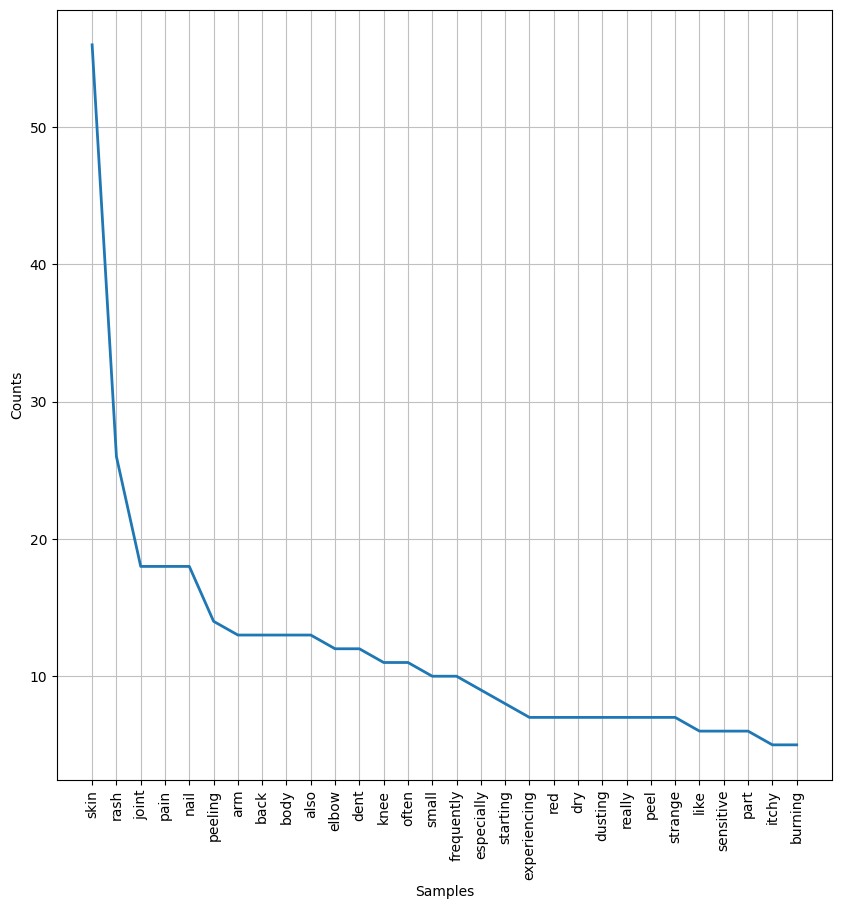

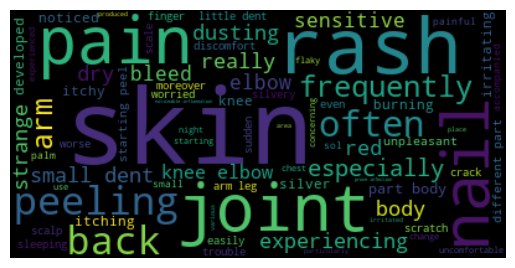

In [7]:
explore_symptoms(df, 'Psoriasis')

#### Example 2: Arthritis

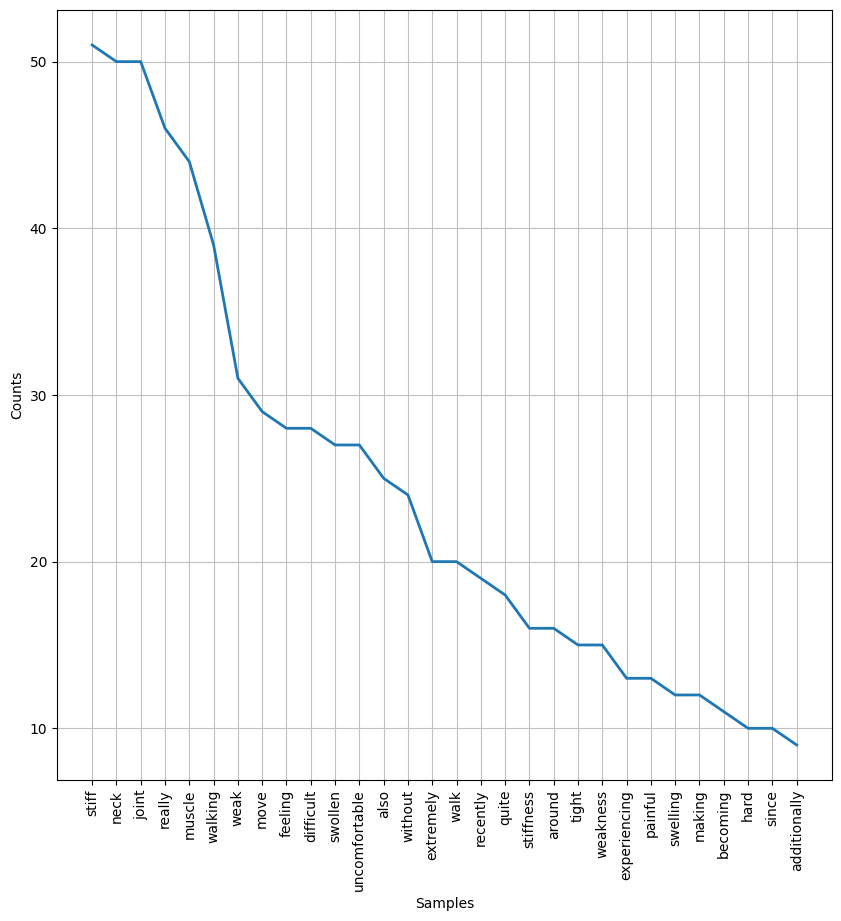

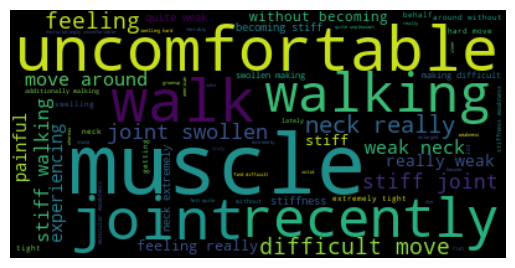

In [8]:
explore_symptoms(df, 'Arthritis')

## Feature Engineering
to pass text data to machine learning algorithm and perform classification

### train-test-split

Since there are only 50 samples from each disease, the split is completed only once, with 30% being the test set.

In [9]:
df['processed_str'] = df['processed'].apply(' '.join)

In [10]:
from sklearn.model_selection import train_test_split

text_data = df['processed_str']
label = df['label']

X_train, X_test, y_train, y_test = train_test_split(text_data, label, test_size=0.3, random_state=42)

### Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

sw = stopwords.words('english') + ["i've", "i'm"]

tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_train_vec = tf_vec.fit_transform(X_train)
X_test_vec = tf_vec.transform(X_test)

In [12]:
df_X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=tf_vec.get_feature_names_out())
df_X_test_vec = pd.DataFrame(X_test_vec.toarray(), columns=tf_vec.get_feature_names_out())

## Classification Modeling

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(df_X_train_vec, y_train)

print(f"Logistic Regression default model\nTrain set accuracy: {lr.score(df_X_train_vec, y_train)}\nTest set accuracy : {lr.score(df_X_test_vec, y_test)}")


Logistic Regression default model
Train set accuracy: 0.9976190476190476
Test set accuracy : 0.9583333333333334


In [14]:
# Grid search
from sklearn.model_selection import GridSearchCV

lr_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'max_iter': [50, 100, 150]
}

lr_gs = GridSearchCV(estimator=lr, param_grid=lr_grid)
lr_gs.fit(df_X_train_vec, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [50, 100, 150],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [15]:
# Best parameters from the grid search above
lr_gs.best_params_

{'C': 10, 'max_iter': 50, 'solver': 'newton-cg'}

In [16]:
# Final logistic regression model and accuracy scores
lr_final = LogisticRegression(C=10, max_iter=50, solver='newton-cg', random_state=42)
lr_final.fit(df_X_train_vec, y_train)

print(f"Logistic Regression default model\nTrain set accuracy: {lr_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {lr_final.score(df_X_test_vec, y_test)}")


Logistic Regression default model
Train set accuracy: 1.0
Test set accuracy : 0.975


In [17]:
def disease_odds(estimator, column_names, disease):
    import numpy as np
    
    coef = list(estimator.coef_)
    classes = list(estimator.classes_)
    idx = classes.index(disease)
    dis_coef = coef[idx]

    odds_coef = {}

    for i in range(len(dis_coef)):
        odds_coef[column_names[i]] = np.exp(dis_coef[i])

    return odds_coef

In [18]:
disease_odds = disease_odds(lr_final, df_X_train_vec.columns, 'Psoriasis')

In [19]:
import operator
max(disease_odds.items(), key=operator.itemgetter(1))[0]

'nail'

### Multinomial Naive Bayes

[Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classification model is especially suitable for having discrete features; thus, it is often used in NLP.

In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(df_X_train_vec, y_train)

print(f"Multinomial Naive Bayse default model\nTrain set accuracy: {mnb.score(df_X_train_vec, y_train)}\nTest set accuracy : {mnb.score(df_X_test_vec, y_test)}")

Multinomial Naive Bayse default model
Train set accuracy: 0.9940476190476191
Test set accuracy : 0.9472222222222222


In [25]:
mnb_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

mnb_gs = GridSearchCV(estimator=mnb, param_grid=mnb_grid)
mnb_gs.fit(df_X_train_vec, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
                         'fit_prior': [True, False]})

In [26]:
mnb_gs.best_params_

{'alpha': 0.1, 'fit_prior': True}

In [27]:
mnb_final = MultinomialNB(alpha=0.1)
mnb_final.fit(df_X_train_vec, y_train)

print(f"Multinomial Naive Bayse final model\nTrain set accuracy: {mnb_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {mnb_final.score(df_X_test_vec, y_test)}")

Multinomial Naive Bayse final model
Train set accuracy: 1.0
Test set accuracy : 0.9694444444444444


### SVM Classifier

In [64]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(df_X_train_vec, y_train)

SVC(random_state=42)

In [65]:
print(f"SVC default model\nTrain set accuracy: {svc.score(df_X_train_vec, y_train)}\nTest set accuracy : {svc.score(df_X_test_vec, y_test)}")

SVC default model
Train set accuracy: 1.0
Test set accuracy : 0.975


In [68]:
svc_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf']
}

svc_gs = GridSearchCV(estimator=svc, param_grid=svc_grid)
svc_gs.fit(df_X_train_vec, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf']})

In [70]:
svc_gs.best_params_

{'C': 10, 'kernel': 'linear'}

In [72]:
svc_final = SVC(C=10, kernel='linear', random_state=42)
svc_final.fit(df_X_train_vec, y_train)

print(f"SVC final model\nTrain set accuracy: {svc_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {svc_final.score(df_X_test_vec, y_test)}")

SVC final model
Train set accuracy: 1.0
Test set accuracy : 0.975


## Prediction



In [59]:
def predict_disease(sample, estimator):
    proc_sample = [' '.join(nlp_preprocessing(sample))]
    proc_sample_vec = pd.DataFrame(tf_vec.transform(proc_sample).toarray(), columns=tf_vec.get_feature_names_out())

    dis_predict = estimator.predict(proc_sample_vec)[0]
    return dis_predict

In [60]:
sample = "I've been dealing with these persistent skin issues for a while. My skin gets all red, scaly, and itchy, especially on my elbows, knees, and scalp. It's not just my skin; my nails have started to change, getting these little dents and turning weird colors. Sometimes, my fingers and toes ache, and it's more painful in the morning or when I've been still for a while. Stress and chilly weather seem to make everything worse. I'm feeling self-conscious about my appearance, and I'm ready to find a solution."

predict_disease(sample, lr_final)

'Psoriasis'

In [61]:
predict_disease(sample, mnb_final)

'Psoriasis'

In [73]:
predict_disease(sample, svc_final)

'Psoriasis'